In [1]:
from dns_attacks_detection import *

El objetivo de este código es analizar diferentes modelos con tres vectores de características, para ver cómo varía el rendimiento entre ellos.

In [2]:
feature_vectors = [extract_features_reduced, extract_features_with_letters_and_numbers,
                   extract_features_with_letter_counting]

for vector in feature_vectors:
    # Load feature vector
    dns = create_feature_vector_from_log_file('3JUL.log', vector)
    train_set, test_set = split_train_and_test_sets(dns, 'attack')
    features = train_set.drop('attack', 1)
    labels = train_set['attack']
    # Initialise models
    sgd_clf = SGDClassifier(max_iter=5, random_state=13)
    log_reg_clf = LogisticRegression(random_state=13, solver='liblinear')
    svm_clf_poly = SVC(kernel='poly', random_state=13, gamma='auto', degree=3, coef0=1, C=5)
    svm_clf_rbf = SVC(kernel='rbf', random_state=13, gamma=5, C=5)
    tree_clf = DecisionTreeClassifier(random_state=13)
    knn_clf = KNeighborsClassifier()
    # Set parameters for cross validation
    models = [sgd_clf, log_reg_clf, svm_clf_poly, svm_clf_rbf, tree_clf, knn_clf]
    names = ['SGDClassifier', 'LogisticRegression', 'SVC Poly', 'SVC RBF', 'DecisionTreeClassifier', 'KNeighborsClassifier']
    scoring = ['precision', 'recall', 'f1']
    # Evaluate models using cross validation
    cv_results = cross_validate_models(models, features, labels, scoring, 5)
    scores = get_cross_validate_scores(cv_results, names, scoring)    
    # Print scores
    print(print_scores(vector.__name__, scores))
    print()

extract_features_reduced
SGDClassifier
precision  0
recall     0
f1         0
LogisticRegression
precision  0
recall     0
f1         0
SVC Poly
precision  0
recall     0
f1         0
SVC RBF
precision  0.627914
recall     0.577622
f1         0.597561
DecisionTreeClassifier
precision  0.976591
recall     0.83683
f1         0.901271
KNeighborsClassifier
precision  0.961603
recall     0.843357
f1         0.898217


extract_features_with_letters_and_numbers
SGDClassifier
precision  0.826542
recall     0.42704
f1         0.562589
LogisticRegression
precision  0.812031
recall     0.384149
f1         0.521378
SVC Poly
precision  0.890943
recall     0.701632
f1         0.785026
SVC RBF
precision  0.909556
recall     0.797203
f1         0.84962
DecisionTreeClassifier
precision  0.978676
recall     0.919347
f1         0.948012
KNeighborsClassifier
precision  0.978683
recall     0.919814
f1         0.948261


extract_features_with_letter_counting
SGDClassifier
precision  0.984714
recall     0.32

Usando el vector de características que cuenta todas las letras y números ("extract_features_with_letter_counting") obtenemos valores de rendimiento bastante altos con tres modelos. Es un vector con muchas características comparado con los otros. Probemos el rendimiento de estos modelos con el "test set" y realizando algunos ajustes en sus parámetros.

In [3]:
dns = create_feature_vector_from_log_file('3JUL.log', extract_features_with_letter_counting)
train_set, test_set = split_train_and_test_sets(dns, 'attack')
features = train_set.drop('attack', 1)
labels = train_set['attack']
features_test = test_set.drop('attack', 1)
labels_test = test_set['attack']

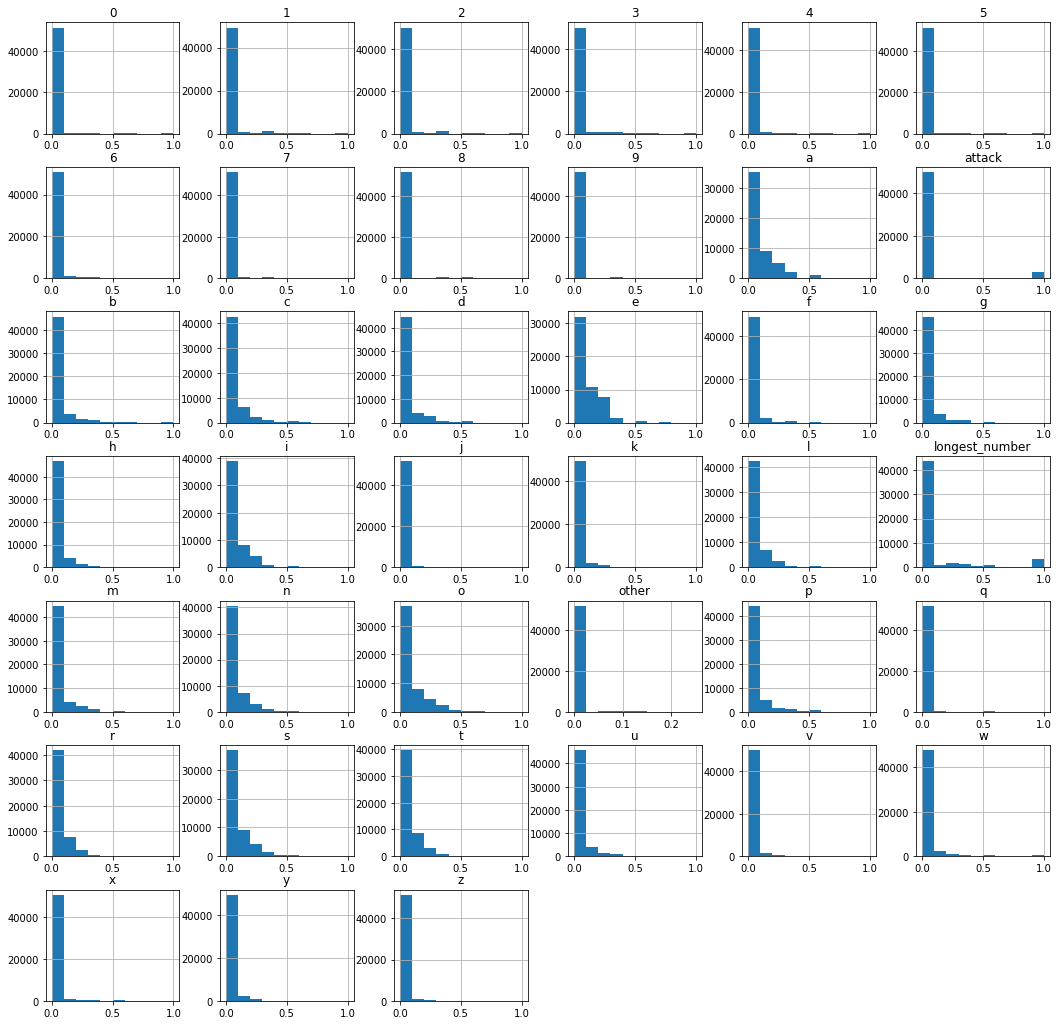

In [23]:
dns.hist(figsize=(18,18))
plt.show()

## Support Vector Machines (Gaussian RBF Kernel)

In [4]:
svm_clf_rbf = SVC(kernel='rbf', random_state=13, gamma=5, C=5)
svm_clf_rbf.fit(features, labels)

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=5, kernel='rbf',
  max_iter=-1, probability=False, random_state=13, shrinking=True,
  tol=0.001, verbose=False)

### Evaluación con el "Test Set"

In [5]:
final_precision, final_recall, final_f1 = evaluate_model_with_precision_and_recall(
    svm_clf_rbf, features_test, labels_test)
print("Precision: ", final_precision, "\nRecall: ", final_recall, "\nF1: ", final_f1)

Precision:  1.0 
Recall:  1.0 
F1:  1.0


### Modificando algunos parámetros

In [6]:
svm_clf_rbf_tuned = SVC(kernel='rbf', random_state=13, gamma=17, C=70)
svm_clf_rbf_tuned.fit(features, labels)

SVC(C=70, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=17, kernel='rbf',
  max_iter=-1, probability=False, random_state=13, shrinking=True,
  tol=0.001, verbose=False)

### Evaluación con el "Test Set"

In [7]:
final_precision, final_recall, final_f1 = evaluate_model_with_precision_and_recall(
    svm_clf_rbf_tuned, features_test, labels_test)
print("Precision: ", final_precision, "\nRecall: ", final_recall, "\nF1: ", final_f1)

Precision:  1.0 
Recall:  0.998134328358 
F1:  0.999066293184


## Decision Trees

In [8]:
tree_clf = DecisionTreeClassifier(random_state=13)
tree_clf.fit(features, labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=13,
            splitter='best')

### Evaluación con el "Test Set"

In [9]:
final_precision, final_recall, final_f1 = evaluate_model_with_precision_and_recall(
    tree_clf, features_test, labels_test)
print("Precision: ", final_precision, "\nRecall: ", final_recall, "\nF1: ", final_f1)

Precision:  1.0 
Recall:  0.986940298507 
F1:  0.993427230047


### Afinación

#### Randomized Search

In [10]:
param_distribs = {
        'max_depth': randint(low=5, high=8),
        'min_samples_split': randint(low=4, high=15),
        'min_samples_leaf': randint(low=3, high=10)
    }
tree_clf_rnd_search = RandomizedSearchCV(tree_clf, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='recall', random_state=13, return_train_score=False)
tree_clf_rnd_search.fit(features, labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=13,
            splitter='best'),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6b21b26550>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6b21b26f98>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6b21b26ba8>},
          pre_dispatch='2*n_jobs', random_state=13, refit=True,
          return_train_score=False, scoring='recall', verbose=0)

In [11]:
search_results = tree_clf_rnd_search.cv_results_
for mean_score, params in zip(search_results['mean_test_score'], search_results['params']):
    print(mean_score, params)

0.921211977214 {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 14}
0.832167832168 {'max_depth': 5, 'min_samples_leaf': 9, 'min_samples_split': 6}
0.838694838077 {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 14}
0.911421302198 {'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 6}
0.904428129053 {'max_depth': 7, 'min_samples_leaf': 9, 'min_samples_split': 9}
0.877389598617 {'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 13}
0.833566555411 {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 4}
0.875524708137 {'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 10}
0.875524708137 {'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 5}
0.921678199833 {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 12}


#### Grid Search

In [12]:
param_grid = {'min_samples_leaf': [4, 8, 12], 'min_samples_split': [8, 12, 15]}
tree_clf_grid_search = GridSearchCV(tree_clf, param_grid, cv=5, scoring='recall', return_train_score=False)
tree_clf_grid_search.fit(features, labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=13,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_leaf': [4, 8, 12], 'min_samples_split': [8, 12, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='recall', verbose=0)

In [13]:
search_results = tree_clf_grid_search.cv_results_
for mean_score, params in zip(search_results['mean_test_score'], search_results['params']):
    print(mean_score, params)

0.964568465495 {'min_samples_leaf': 4, 'min_samples_split': 8}
0.965034521963 {'min_samples_leaf': 4, 'min_samples_split': 12}
0.965500855351 {'min_samples_leaf': 4, 'min_samples_split': 15}
0.947784506566 {'min_samples_leaf': 8, 'min_samples_split': 8}
0.947784506566 {'min_samples_leaf': 8, 'min_samples_split': 12}
0.947784506566 {'min_samples_leaf': 8, 'min_samples_split': 15}
0.930069154694 {'min_samples_leaf': 12, 'min_samples_split': 8}
0.930069154694 {'min_samples_leaf': 12, 'min_samples_split': 12}
0.930069154694 {'min_samples_leaf': 12, 'min_samples_split': 15}


#### Evaluación con el "Test Set"

In [14]:
tree_clf_tuned = DecisionTreeClassifier(random_state=13, min_samples_leaf=10, min_samples_split=15)
tree_clf_tuned.fit(features, labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=15,
            min_weight_fraction_leaf=0.0, presort=False, random_state=13,
            splitter='best')

In [15]:
final_precision, final_recall, final_f1 = evaluate_model_with_precision_and_recall(
    tree_clf_tuned, features_test, labels_test)
print("Precision: ", final_precision, "\nRecall: ", final_recall, "\nF1: ", final_f1)

Precision:  0.998065764023 
Recall:  0.962686567164 
F1:  0.980056980057


## K-Nearest-Neighbors

In [16]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(features, labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

### Evaluación con el "Test Set"

In [17]:
final_precision, final_recall, final_f1 = evaluate_model_with_precision_and_recall(
    knn_clf, features_test, labels_test)
print("Precision: ", final_precision, "\nRecall: ", final_recall, "\nF1: ", final_f1)

Precision:  1.0 
Recall:  0.975746268657 
F1:  0.987724268178


Después de analizar los modelos más prometedores con el vector de características más extenso y de realizar algunos ajustes en sus parámetros, elegimos los modelos con los siguientes resultados:

- Support Vector Machines (Gaussian RBF Kernel): {'C': 5, 'gamma': 5}. Exhaustividad: 1.0 en el "test set".
- Decision Trees: parámetros por defecto ({'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}). Exhaustividad: 0.98 en el "test set".
- K-Nearest-Neighbors: parámetros por defecto ({'n_neighbors': 5, 'weights': 'uniform'}). Exhaustividad: 0.97 en el "test set".

Guardemos estos modelos para poder usarlos más tarde.

In [18]:
directory = './models/extract_features_with_letter_counting/'
joblib.dump(svm_clf_rbf, directory + 'support_vector_machines_RBF_kernel.pkl')
joblib.dump(tree_clf, directory + 'decision_trees.pkl')
joblib.dump(knn_clf, directory + 'k_nearest_neighbors.pkl')

['./models/extract_features_with_letter_counting/k_nearest_neighbors.pkl']